# 1. Importing packages

In [92]:
import tensorflow as tf
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import cv2
import random
import os

from tensorflow.keras.layers import Input , Dense , Flatten , GlobalAveragePooling2D
from tensorflow.keras.models import Sequential

In [93]:
path = '../input/4-animal-classification'

# 2. Visualising data

In [94]:
names = []
nums = []
data = {'Name of class':[],'Number of samples':[]}

for i in os.listdir(path+'/train'):
    nums.append(len(os.listdir(path+'/train/'+i)))
    names.append(i)

data['Name of class']+=names
data['Number of samples']+=nums

df = pd.DataFrame(data)
df

,Name of class,Number of samples
0,horse,600
1,dog,900
2,cat,700
3,deer,600


<AxesSubplot:xlabel='Name of class', ylabel='Number of samples'>

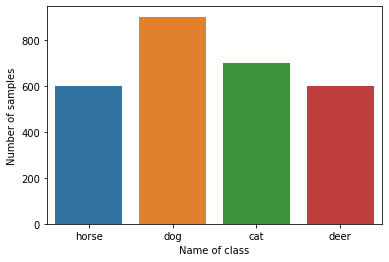

In [95]:
sns.barplot(x=df['Name of class'],y=df['Number of samples'])

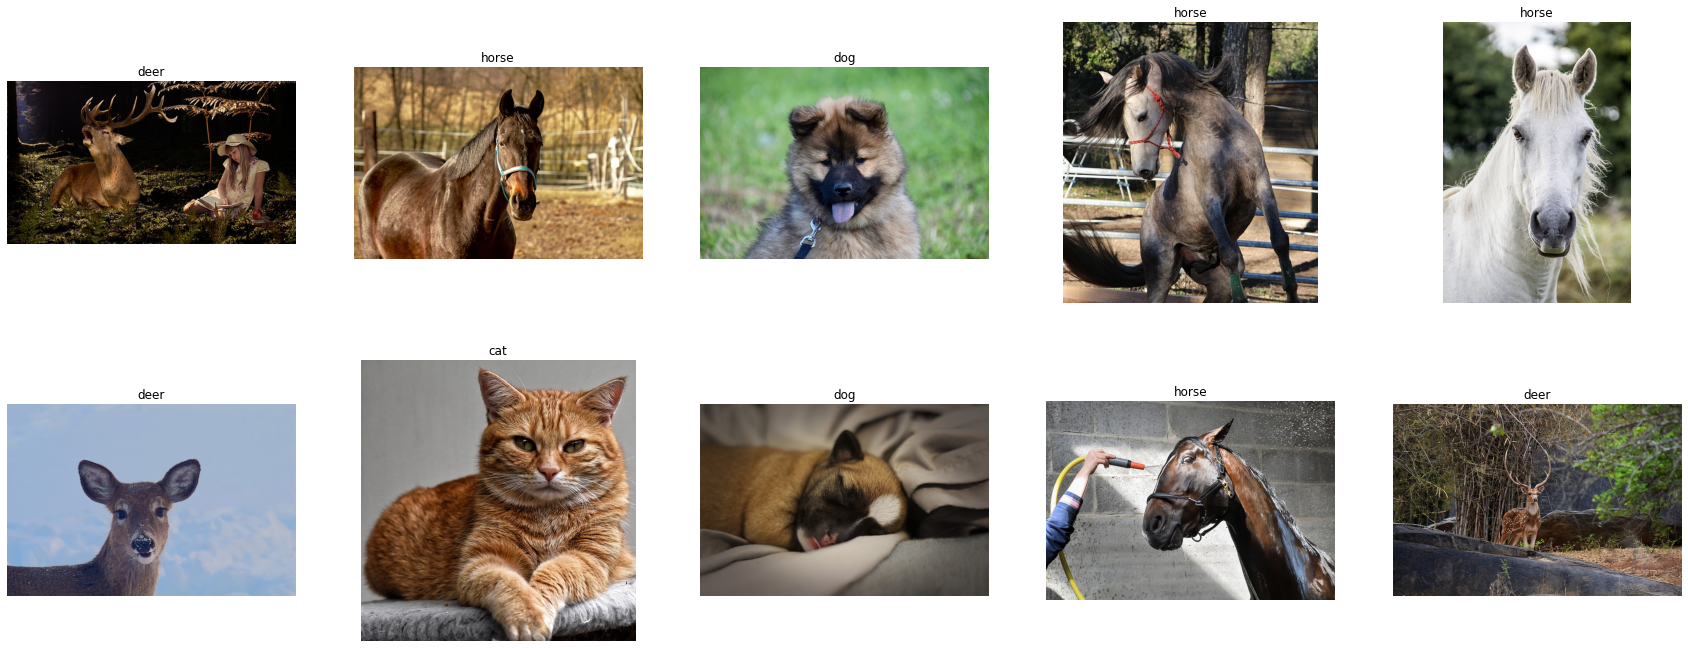

In [96]:
classes = os.listdir(path+'/train')

plt.figure(figsize=(30 , 30))
for x in range(10):
    i = random.randint(0,3)                    # getting the class
    images = os.listdir(path+'/train'+'/'+classes[i])
    j = random.randint(0,600)                  # getting the image
    image = cv2.imread(path+'/train'+'/'+classes[i]+'/'+images[j])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    ax = plt.subplot(5, 5, x + 1)
    plt.imshow(image)
    plt.title(classes[i])
    plt.axis("off")

plt.show()

# 3. Preparing the data

In [97]:
image_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./255 , rotation_range=20,
                                                                width_shift_range=0.2,
                                                                height_shift_range=0.2,
                                                                horizontal_flip=True, validation_split=0.2)

In [98]:
train_ds = image_datagen.flow_from_directory(
        path+'/train',
        subset='training',
        target_size=(224 , 224),
        batch_size=64)

val_ds = image_datagen.flow_from_directory(
        path+'/train',
        subset='validation',
        target_size=(224 , 224),
        batch_size=64 )

Found 2240 images belonging to 4 classes.
Found 560 images belonging to 4 classes.


# 4. Building the model

In [99]:
# i'll be using inception_v3 for this model , along with 2 extra dense layers and the output layer

mobilenet = tf.keras.applications.DenseNet201(input_shape=(224, 224, 3),
                                           include_top=False,
                                           weights='imagenet')

model = Sequential()
model.add(mobilenet)
model.add(GlobalAveragePooling2D())
model.add(Flatten())
model.add(Dense(1024, activation="relu"))
model.add(Dense(512, activation="relu"))
model.add(Dense(4, activation="softmax" , name="classification"))

74850304/74836368 [==============================] - 1s 0us/step


In [100]:
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.0009,momentum=0.9), 
            loss='categorical_crossentropy',
            metrics = ['accuracy'])

model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet201 (Functional)     (None, 7, 7, 1920)        18321984  
_________________________________________________________________
global_average_pooling2d_6 ( (None, 1920)              0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 1920)              0         
_________________________________________________________________
dense_12 (Dense)             (None, 1024)              1967104   
_________________________________________________________________
dense_13 (Dense)             (None, 512)               524800    
_________________________________________________________________
classification (Dense)       (None, 4)                 2052      
Total params: 20,815,940
Trainable params: 20,586,884
Non-trainable params: 229,056
____________________________________

# 5. Training and evaluating

In [101]:
history = model.fit(train_ds , validation_data = val_ds , epochs = 15)

Epoch 1/15


2022-09-25 10:43:06.512961: W tensorflow/core/common_runtime/bfc_allocator.cc:272] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.71GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2022-09-25 10:43:07.356474: W tensorflow/core/common_runtime/bfc_allocator.cc:272] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.59GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.


35/35 [==============================] - ETA: 0s - loss: 0.9093 - accuracy: 0.6844

2022-09-25 10:44:06.159998: W tensorflow/core/common_runtime/bfc_allocator.cc:272] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.65GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.


35/35 [==============================] - 77s 2s/step - loss: 0.9093 - accuracy: 0.6844 - val_loss: 0.3696 - val_accuracy: 0.9107
Epoch 2/15
35/35 [==============================] - 55s 2s/step - loss: 0.2185 - accuracy: 0.9616 - val_loss: 0.1326 - val_accuracy: 0.9607
Epoch 3/15
35/35 [==============================] - 55s 2s/step - loss: 0.1041 - accuracy: 0.9737 - val_loss: 0.1029 - val_accuracy: 0.9679
Epoch 4/15
35/35 [==============================] - 54s 2s/step - loss: 0.0617 - accuracy: 0.9857 - val_loss: 0.0861 - val_accuracy: 0.9768
Epoch 5/15
35/35 [==============================] - 55s 2s/step - loss: 0.0465 - accuracy: 0.9893 - val_loss: 0.0804 - val_accuracy: 0.9732
Epoch 6/15
35/35 [==============================] - 56s 2s/step - loss: 0.0345 - accuracy: 0.9929 - val_loss: 0.0884 - val_accuracy: 0.9732
Epoch 7/15
35/35 [==============================] - 56s 2s/step - loss: 0.0319 - accuracy: 0.9929 - val_loss: 0.0770 - val_accuracy: 0.9750
Epoch 8/15
35/35 [=============

9/9 [==============================] - 10s 1s/step - loss: 0.0681 - accuracy: 0.9821


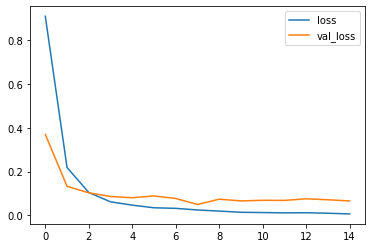

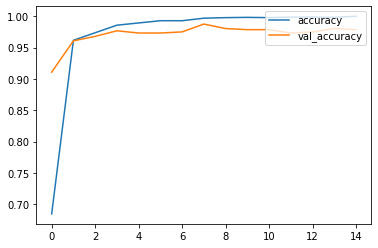

In [102]:
model.evaluate(val_ds)

plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['loss','val_loss'],loc='upper right')
plt.show()
plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['accuracy','val_accuracy'],loc='upper right')
plt.show()

# 6. Preparing for submission

In [103]:
sub_csv ='../input/4-animal-classification/Sample_submission.csv'
path_test = '../input/4-animal-classification/test/test'

In [104]:
df_sub = pd.read_csv(sub_csv)
image_id = df_sub['ID']
df_sub.head(10)

,ID,Label
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0
5,6,0
6,7,0
7,8,0
8,9,0
9,10,0


In [109]:
# each image will be treated individually and saved in a list which is then merged with the id of it's correspondence

from tensorflow.keras.preprocessing.image import load_img


# making a list for our predictions
labels = []


for i in image_id:
    image = load_img(path_test+'/'+str(i)+'.jpg', target_size=(224, 224))
    img = np.array(image)
    img = img / 255.0
    img = img.reshape(1,224,224,3)
    label = model.predict(img)
    label_id = label[0].tolist()
    
    labels.append(label_id.index(max(label_id)))


In [106]:
# we will replace the previous empty columns with the new predictions    
    
df_sub['Label'] = labels
df_sub.head(10)

,ID,Label
0,1,1
1,2,0
2,3,2
3,4,3
4,5,2
5,6,1
6,7,3
7,8,0
8,9,3
9,10,2


In [107]:
# saving file
df_sub.to_csv('submission_file.csv',index=False)